In [1]:

import tensorflow as tf
import numpy as np
import pickle as pk
import time
import pandas as pd 
import csv
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
# import matplotlib.pyplot as plt

In [2]:
#configurations
project ='/fake news detection/dataset/'
directory = '/home/ngls/Documents/private repository/data science' + project


In [3]:
# load data set
train = pd.read_csv(directory+'train_merged.csv', error_bad_lines=False,encoding='latin-1', engine='python')
test =  pd.read_csv(directory+'test_merged.csv',  error_bad_lines=False,encoding='latin-1', engine='python')
# train = train[:1000]
# test =test[:1000]

In [6]:
train.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed Spider Man after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [8]:
train['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [5]:
train.describe()

,Body ID
count,49972.000000
mean,1366.254863
std,730.086644
min,0.000000
25%,737.750000
50%,1419.000000
75%,2002.000000
max,2532.000000


In [4]:
totaldata= train['articleBody'].tolist() + train['Headline'].tolist()+test['articleBody'].tolist()+test['Headline'].tolist()
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=80, stop_words='english')
tfidf_vect.fit(totaldata)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=80,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)

In [5]:
#Total data
train_head_vec= tfidf_vect.transform(train['Headline'])
train_body_vec= tfidf_vect.transform(train['articleBody'])
test_head_vec= tfidf_vect.transform(test['Headline'])
test_body_vec= tfidf_vect.transform(test['articleBody'])

In [6]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/ngls/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ngls/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:

_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)




def word_overlap_features(features, headline, body):
    # common word/ total word
    clean_headline = clean(headline)
    clean_body = clean(body)
    clean_headline = get_tokenized_lemmas(clean_headline)
    clean_body = get_tokenized_lemmas(clean_body)
    feature = len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))
    features.append(feature)
    return features




def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):
    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    def other_feature(headline, body):
        features=[]
        features= word_overlap_features(features, headline, body)
        return features
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        lst= binary_co_occurence(headline, body) + binary_co_occurence_stops(headline, body) + count_grams(headline, body)+ other_feature(headline, body)
        X.append(lst)


    X =np.array(X)
    return X

In [9]:
train_handF= hand_features(train['Headline'].tolist(), train['articleBody'].tolist())
test_handF=hand_features(test['Headline'].tolist(), test['articleBody'].tolist())

1000it [00:28, 34.90it/s]
1000it [00:14, 66.73it/s]


In [10]:
from scipy.sparse import  hstack
train_final= hstack([train_head_vec,train_body_vec]).toarray()
test_final= hstack([test_head_vec,test_body_vec]).toarray()


In [11]:
train_final =np.concatenate((train_final,train_handF), axis=1)
test_final =np.concatenate((test_final,test_handF), axis=1)
print(type(train_final), train_final.shape, test_final.shape)

<class 'numpy.ndarray'> (1000, 187) (1000, 187)


In [12]:
#Data processing
train_final =np.concatenate((train_final,train_handF), axis=1)
test_final =np.concatenate((test_final,test_handF), axis=1)
print(type(train_final), train_final.shape, test_final.shape)
train.head()

<class 'numpy.ndarray'> (1000, 214) (1000, 214)


,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed Spider Man after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


In [13]:
train_labels= train['Stance'].copy()
test_labels= test['Stance'].copy()
train_labels.value_counts()
test_labels.value_counts()

unrelated    954
discuss       33
agree         13
Name: Stance, dtype: int64

In [14]:
from sklearn.metrics import accuracy_score


from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.34)
mnb.fit(train_final, train_labels)

MultinomialNB(alpha=0.34, class_prior=None, fit_prior=True)

In [15]:
x=[]
def convert(df , new_df):
    del x[:]
    for i in df:
        if(i=="unrelated"):
            new_df.append(0)
        elif (i=="discuss"):
            new_df.append(1)
        elif (i=="agree"):
            new_df.append(2)
        else:
            new_df.append(3)
    return new_df
convert(train_labels,x)

final_train_labels = np.asarray(convert(train_labels,x), dtype=np.float32)
final_test_labels = np.asarray(convert(test_labels,x), dtype=np.float32)






(1000,)

In [18]:
# sequential model
y_train= train_labels.to_numpy()
y_test = test_labels.to_numpy()
model = Sequential()
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(train_final,final_train_labels, batch_size=100, epochs=10, validation_data=(test_final,final_train_labels))

Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6848 - accuracy: 0.5350 - val_loss: 0.5108 - val_accuracy: 0.9290
Epoch 2/20
1000/1000 [==============================] - 0s 344us/sample - loss: 0.4679 - accuracy: 0.9420 - val_loss: 0.3774 - val_accuracy: 0.9590
Epoch 3/20
1000/1000 [==============================] - 0s 366us/sample - loss: 0.3554 - accuracy: 0.9650 - val_loss: 0.3173 - val_accuracy: 0.9610
Epoch 4/20
1000/1000 [==============================] - 0s 234us/sample - loss: 0.3000 - accuracy: 0.9650 - val_loss: 0.2869 - val_accuracy: 0.9610
Epoch 5/20
1000/1000 [==============================] - 0s 277us/sample - loss: 0.2655 - accuracy: 0.9650 - val_loss: 0.2750 - val_accuracy: 0.9610
Epoch 6/20
1000/1000 [==============================] - 0s 410us/sample - loss: 0.2397 - accuracy: 0.9650 - val_loss: 0.2683 - val_accuracy: 0.9600
Epoch 7/20
1000/1000 [==============================] - 0s 300us/s

In [63]:
#testing naive bayes
prediction = mnb.predict(test_final)
accuracy = accuracy_score(test_labels,prediction)*100
print(str(accuracy)+ "%")

90.5%


In [44]:
np.unique(prediction)

array(['agree', 'discuss', 'unrelated'], dtype='<U9')

In [45]:
prediction = mnb.predict(test_final)
accuracy_score(test_labels,prediction)

0.905

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
matrix1 = confusion_matrix(test_labels, prediction)

In [47]:
matrix1

array([[  4,   8,   1],
       [  9,  21,   3],
       [  3,  71, 880]])

In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

 
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

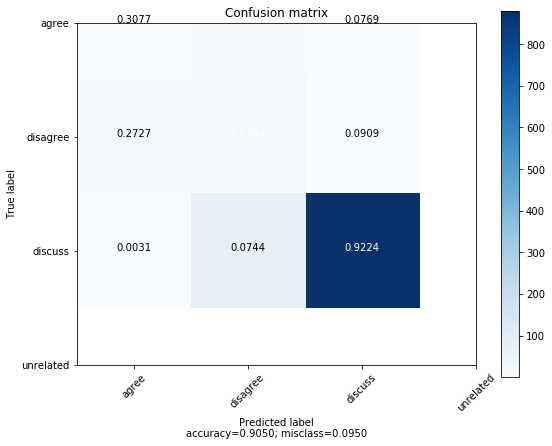

In [49]:
plot_confusion_matrix(cm=matrix1,target_names=['agree', 'disagree', 'discuss', 'unrelated'])

In [50]:
train['Stance']train_labels

unrelated    965
discuss       20
agree         15
Name: Stance, dtype: int64

In [51]:
test['Stance'].value_counts()

unrelated    954
discuss       33
agree         13
Name: Stance, dtype: int64